# Liverpool All accidents per ward per capita 

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/3371839532.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


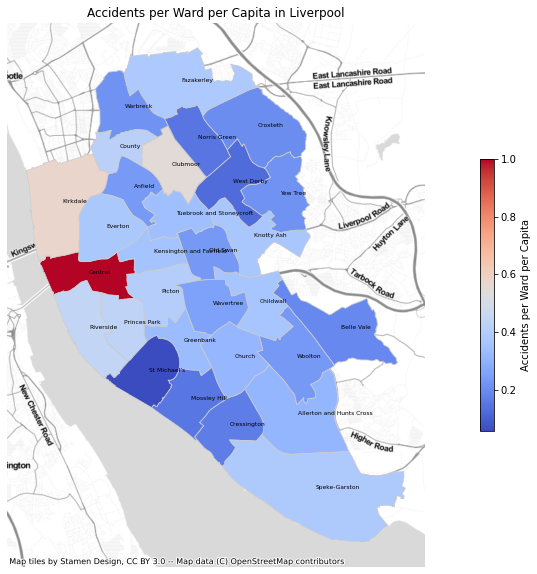

In [12]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Filter data to show accidents in Liverpool
liverpool_data = df[(df["local_authority_district"] == "Liverpool")]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the liverpool_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
liverpool_wards_gdf = liverpool_wards_gdf.assign(
    total_population=liverpool_wards_gdf["wd15nm"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward 
liverpool_wards_gdf["accidents_per_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_capita"] = liverpool_wards_gdf["accidents_per_capita"] / liverpool_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis("off")
ax.set_title("Accidents per Ward per Capita in Liverpool")
plt.savefig("liverpool_wards_accidents_per_capita.png", dpi=600, bbox_inches="tight")
plt.show()




In [41]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])




3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object


# Liverpool Cyclist

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/2279562243.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


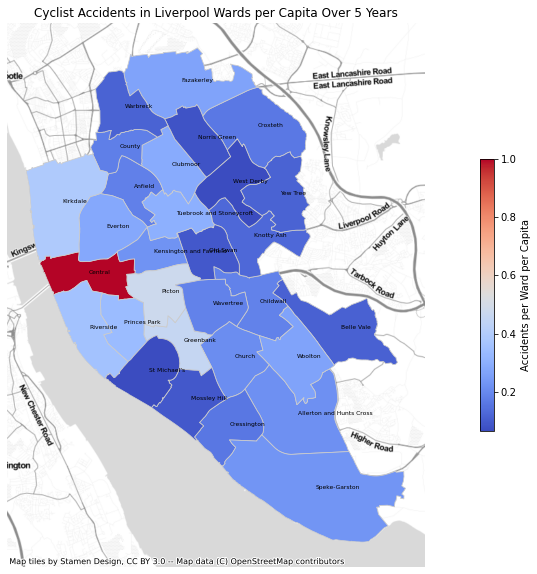

In [14]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool") & (df["casualty_type"] == "Cyclist")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the liverpool_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
liverpool_wards_gdf = liverpool_wards_gdf.assign(
    total_population=liverpool_wards_gdf["wd15nm"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward 
liverpool_wards_gdf["accidents_per_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_capita"] = liverpool_wards_gdf["accidents_per_capita"] / liverpool_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')



# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Cyclist Accidents in Liverpool Wards per Capita Over 5 Years')
plt.savefig('cyclist_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [40]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])




3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object


# Pedestrian Liverpool

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/2146162991.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


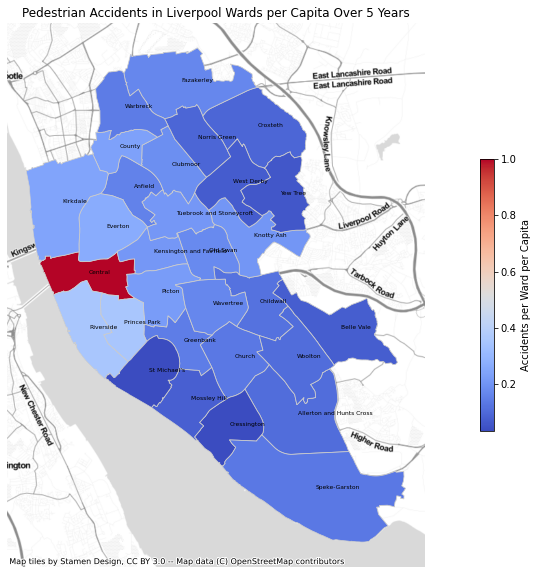

In [16]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool") & (df["casualty_type"] == "Pedestrian")]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Calculate the total population per ward
total_pop_per_ward = pop_df.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_pop_per_ward.columns = ["Ward_Name", "Total Population"]

# Extract the first word from the ward names
total_pop_per_ward["First_Word"] = total_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the liverpool_wards_gdf with the total_pop_per_ward DataFrame by matching the ward names
liverpool_wards_gdf = liverpool_wards_gdf.assign(
    total_population=liverpool_wards_gdf["wd15nm"].apply(
        lambda x: total_pop_per_ward.loc[total_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Population"].sum()
    )
)

# Calculate accidents per capita for each ward 
liverpool_wards_gdf["accidents_per_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["total_population"]



# Normalize accidents_per_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_capita"] = liverpool_wards_gdf["accidents_per_capita"] / liverpool_wards_gdf["accidents_per_capita"].max()

# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')


# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Pedestrian Accidents in Liverpool Wards per Capita Over 5 Years')
plt.savefig('Pedestrian_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()


In [39]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])




3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object


# Children Under 16 Liverpool

/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/2427004275.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


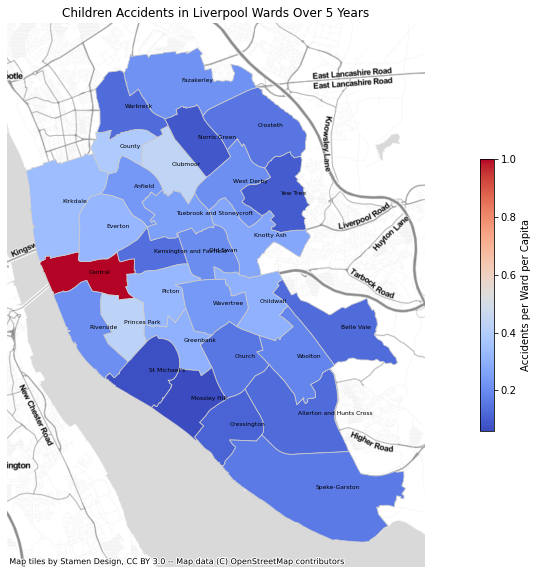

In [18]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool") & (df["age_of_casualty"] < 16)]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)






# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")


#############


# Filter the population data to include only children aged 15 years and under
pop_df_children = pop_df[pop_df["Age (6 categories)"] == "Aged 15 years and under"]

# Calculate the total population of children per ward
total_children_pop_per_ward = pop_df_children.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_children_pop_per_ward.columns = ["Ward_Name", "Total Children Population"]

# Extract the first word from the ward names
total_children_pop_per_ward["First_Word"] = total_children_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

# Merge the liverpool_wards_gdf with the total_children_pop_per_ward DataFrame by matching the ward names
liverpool_wards_gdf = liverpool_wards_gdf.assign(
    total_children_population=liverpool_wards_gdf["wd15nm"].apply(
        lambda x: total_children_pop_per_ward.loc[total_children_pop_per_ward["Ward_Name"].str.startswith(x.split(" ")[0]), "Total Children Population"].sum()
    )
)

# Calculate accidents per child capita for each ward
liverpool_wards_gdf["accidents_per_child_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["total_children_population"]

# Normalize accidents_per_child_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_child_capita"] = liverpool_wards_gdf["accidents_per_child_capita"] / liverpool_wards_gdf["accidents_per_child_capita"].max()


#############




# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_child_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Liverpool Wards Over 5 Years')
plt.savefig('Children_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [38]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])




3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object


In [22]:
# pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/3557903805.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


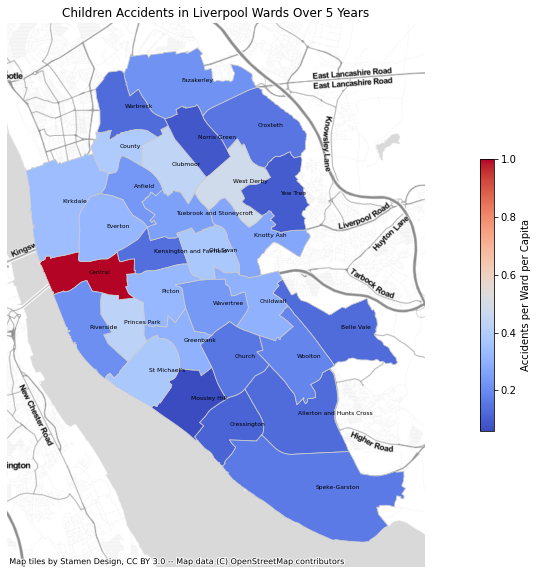

In [23]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')


# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool") & (df["age_of_casualty"] < 16)]


# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)

# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")


#############


# Filter the population data to include only children aged 15 years and under
pop_df_children = pop_df[pop_df["Age (6 categories)"] == "Aged 15 years and under"]

# Calculate the total population of children per ward
total_children_pop_per_ward = pop_df_children.groupby("Electoral wards and divisions")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_children_pop_per_ward.columns = ["Ward_Name", "Total Children Population"]

# Extract the first word from the ward names
total_children_pop_per_ward["First_Word"] = total_children_pop_per_ward["Ward_Name"].apply(lambda x: x.split(" ")[0])

from fuzzywuzzy import process

def get_best_match(ward_name, ward_name_list):
    best_match = process.extractOne(ward_name, ward_name_list)
    return best_match[0] if best_match else None

# Merge the liverpool_wards_gdf with the total_children_pop_per_ward DataFrame by matching the ward names
liverpool_wards_gdf = liverpool_wards_gdf.assign(
    total_children_population=liverpool_wards_gdf["wd15nm"].apply(
        lambda x: total_children_pop_per_ward.loc[
            total_children_pop_per_ward["Ward_Name"] == get_best_match(x, total_children_pop_per_ward["Ward_Name"].tolist()),
            "Total Children Population"
        ].sum()
    )
)


# Calculate accidents per child capita for each ward
liverpool_wards_gdf["accidents_per_child_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["total_children_population"]

# Normalize accidents_per_child_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_child_capita"] = liverpool_wards_gdf["accidents_per_child_capita"] / liverpool_wards_gdf["accidents_per_child_capita"].max()


#############




# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_child_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Liverpool Wards Over 5 Years')
plt.savefig('Children_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()

In [37]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])




3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object


/var/folders/qc/8g9s30t137gcv5sw4mjzcv4c0000gn/T/ipykernel_94189/4003303364.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')
/Users/ahsan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


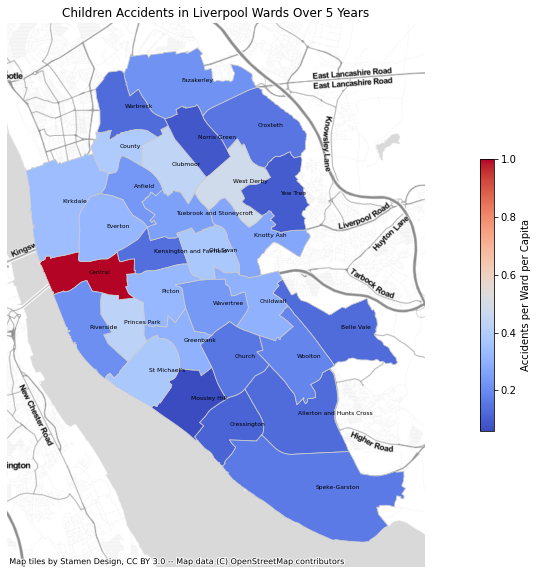

In [27]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Read the data from the CSV file
df = pd.read_csv('cleaned_data.csv')

# Filter data to show accidents in Liverpool involving cyclists
liverpool_data = df[(df["local_authority_district"] == "Liverpool") & (df["age_of_casualty"] < 16)]

# Create a GeoDataFrame from the accident dataset
geometry = gpd.points_from_xy(liverpool_data["longitude"], liverpool_data["latitude"])
accidents_gdf = gpd.GeoDataFrame(liverpool_data, geometry=geometry)

# Set the CRS for the accidents GeoDataFrame
accidents_gdf.crs = "EPSG:4326"

# Read the Liverpool wards shapefile
wards_shapefile = "Wards_Dec_2015_FCB_GB.shp"
wards_gdf = gpd.read_file(wards_shapefile)

# Filter wards_gdf to include only Liverpool wards
liverpool_wards_gdf = wards_gdf[wards_gdf["lad15nm"] == "Liverpool"]

# Convert the CRS of the accidents GeoDataFrame and Liverpool wards GeoDataFrame to Web Mercator (EPSG:3857) for the basemap
accidents_gdf = accidents_gdf.to_crs("EPSG:3857")
liverpool_wards_gdf = liverpool_wards_gdf.to_crs("EPSG:3857")

# Perform a spatial join between the accidents GeoDataFrame and the Liverpool wards GeoDataFrame
joined_data = gpd.sjoin(accidents_gdf, liverpool_wards_gdf, op='within')

# Calculate the number of accidents per ward
accidents_per_ward = joined_data.groupby("wd15nm")["wd15nm"].count()

# Add the number of accidents to the Liverpool wards GeoDataFrame
liverpool_wards_gdf["accidents"] = liverpool_wards_gdf["wd15nm"].map(accidents_per_ward).fillna(0)



# Read the wards_population.csv file
pop_df = pd.read_csv("wards_population.csv")

# Filter the population data to include only children aged 15 years and under
pop_df_children = pop_df[pop_df["Age (6 categories)"] == "Aged 15 years and under"]

# Calculate the total population of children per ward
total_children_pop_per_ward = pop_df_children.groupby("Electoral wards and divisions Code")["Observation"].sum().reset_index()

# Rename the columns for easier merging
total_children_pop_per_ward.rename(columns={"Electoral wards and divisions Code": "wd15cd", "Observation": "Total Children Population"}, inplace=True)

# Merge the liverpool_wards_gdf with the total_children_pop_per_ward DataFrame by matching the ward codes
liverpool_wards_gdf = liverpool_wards_gdf.merge(total_children_pop_per_ward[['wd15cd', 'Total Children Population']], on='wd15cd')




# Calculate accidents per child capita for each ward
liverpool_wards_gdf["accidents_per_child_capita"] = liverpool_wards_gdf["accidents"] / liverpool_wards_gdf["Total Children Population"]



                                                                                                                                       
# Normalize accidents_per_child_capita to the range [0, 1]
liverpool_wards_gdf["normalized_accidents_per_child_capita"] = liverpool_wards_gdf["accidents_per_child_capita"] / liverpool_wards_gdf["accidents_per_child_capita"].max()


#############




# Plot the map with normalized accidents per capita
fig, ax = plt.subplots(1, figsize=(20, 10))
liverpool_wards_gdf.plot(column="normalized_accidents_per_child_capita", cmap="coolwarm", linewidth=0.8, edgecolor="0.8", legend=True, ax=ax,
                          legend_kwds={"shrink": 0.5, "label": "Accidents per Ward per Capita"}, vmax=1)

# Calculate unique ward centroids
unique_ward_centroids = liverpool_wards_gdf.dissolve(by="wd15nm", aggfunc="sum").reset_index()

# Add unique ward names to the map without the word "Ward" and without the last part that has "&" in it
for _, row in unique_ward_centroids.iterrows():
    ward_name = row["wd15nm"].replace("Ward", "").strip()
#     ward_name = ward_name.split('&')[0].strip()
    ax.annotate(ward_name, xy=row["geometry"].centroid.coords[0], xytext=(0, 0), textcoords="offset points", fontsize=6, color='black')

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=12)
ax.axis('off')
ax.set_title('Children Accidents in Liverpool Wards Over 5 Years')
plt.savefig('Children_liverpool_wards_accidents.png', dpi=600, bbox_inches='tight')  # Save the figure with a higher DPI
plt.show()                                                                                                                                       
                                                                                                                                       

In [36]:
top_5_wards = liverpool_wards_gdf.sort_values(by='accidents_per_child_capita', ascending=False).head(5)
print(top_5_wards['wd15nm'])



3          Central
27      West Derby
6         Clubmoor
20    Princes Park
7           County
Name: wd15nm, dtype: object
